In [1]:
%pip install tensorflow tensorflow_datasets matplotlib numpy

import tensorflow as tf
import tensorflow_datasets as tfds
from datasetB_main import MyDataset
import numpy as np
import matplotlib.pyplot as plt
import tempfile
import os
import datetime


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [2]:
import shutil
shutil.rmtree('./tmp2')
tmp_dir = tempfile.mkdtemp()

builder = MyDataset(data_dir='tmp2')
builder.download_and_prepare(
	download_dir='tmp2',
	download_config=tfds.download.DownloadConfig(manual_dir='tmp2')
)
dataset_train_raw = builder.as_dataset(split='train')
dataset_test_raw = builder.as_dataset(split='test')
dataset_val_raw = builder.as_dataset(split='val')
dataset_info = builder.info

print(dataset_info)

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling tmp2\my_dataset\incomplete.4N9SYJ_1.0.0\my_dataset-train.tfrecord*...:   0%|          | 0/3360 [00:0…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling tmp2\my_dataset\incomplete.4N9SYJ_1.0.0\my_dataset-test.tfrecord*...:   0%|          | 0/720 [00:00<…

Generating val examples...: 0 examples [00:00, ? examples/s]

Shuffling tmp2\my_dataset\incomplete.4N9SYJ_1.0.0\my_dataset-val.tfrecord*...:   0%|          | 0/720 [00:00<?…

Dataset my_dataset downloaded and prepared to tmp2\my_dataset\1.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='my_dataset',
    full_name='my_dataset/1.0.0',
    description="""
    Dataset B pour le pierre papier ciseaux
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/my_dataset',
    data_dir='tmp2\\my_dataset\\1.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=91.77 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=720, num_shards=1>,
        'train': <SplitInfo num_examples=3360, num_shards=1>,
        'val': <SplitInfo num_examples=720, num_shards=1>,
    },
    citation="""""",
)


In [3]:
print('Raw train dataset:', dataset_train_raw)
print('Raw train dataset size:', len(dataset_train_raw), '\n')

print('Raw test dataset:', dataset_test_raw)
print('Raw test dataset size:', len(dataset_test_raw), '\n')

print('Raw val dataset:', dataset_val_raw)
print('Raw val dataset size:', len(dataset_val_raw), '\n')

Raw train dataset: <_PrefetchDataset element_spec={'image': TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
Raw train dataset size: 3360 

Raw test dataset: <_PrefetchDataset element_spec={'image': TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
Raw test dataset size: 720 

Raw val dataset: <_PrefetchDataset element_spec={'image': TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
Raw val dataset size: 720 



In [4]:
NUM_TRAIN_EXAMPLES = dataset_info.splits['train'].num_examples
NUM_TEST_EXAMPLES = dataset_info.splits['test'].num_examples
NUM_VAL_EXAMPLES = dataset_info.splits['val'].num_examples
NUM_CLASSES = dataset_info.features['label'].num_classes

print('Number of TRAIN examples:', NUM_TRAIN_EXAMPLES)
print('Number of TEST examples:', NUM_TEST_EXAMPLES)
print('Number of VAL examples:', NUM_VAL_EXAMPLES)
print('Number of label classes:', NUM_CLASSES)

Number of TRAIN examples: 3360
Number of TEST examples: 720
Number of VAL examples: 720
Number of label classes: 3


In [5]:
INPUT_IMG_SIZE_ORIGINAL = dataset_info.features['image'].shape[0]
INPUT_IMG_SHAPE_ORIGINAL = dataset_info.features['image'].shape

INPUT_IMG_SIZE_REDUCED = INPUT_IMG_SIZE_ORIGINAL // 2
INPUT_IMG_SHAPE_REDUCED = (
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SHAPE_ORIGINAL[2]
)

# Here we may switch between bigger or smaller image sized that we will train our model on.
INPUT_IMG_SIZE = INPUT_IMG_SIZE_REDUCED
INPUT_IMG_SHAPE = INPUT_IMG_SHAPE_REDUCED

print('Input image size (original):', INPUT_IMG_SIZE_ORIGINAL)
print('Input image shape (original):', INPUT_IMG_SHAPE_ORIGINAL)
print('\n')
print('Input image size (reduced):', INPUT_IMG_SIZE_REDUCED)
print('Input image shape (reduced):', INPUT_IMG_SHAPE_REDUCED)
print('\n')
print('Input image size:', INPUT_IMG_SIZE)
print('Input image shape:', INPUT_IMG_SHAPE)

Input image size (original): 300
Input image shape (original): (300, 300, 3)


Input image size (reduced): 150
Input image shape (reduced): (150, 150, 3)


Input image size: 150
Input image shape: (150, 150, 3)


In [6]:
# Function to convert label ID to labels string.
get_label_name = dataset_info.features['label'].int2str

In [7]:
print(get_label_name(0))
print(get_label_name(1))
print(get_label_name(2))

rock
paper
scissors


In [8]:
def preview_dataset(dataset):
    plt.figure(figsize=(12, 12))
    plot_index = 0
    for features in dataset.take(12):
        image = features['image']
        label = features['label']
        plot_index += 1
        plt.subplot(3, 4, plot_index)
        # plt.axis('Off')
        plt.title('Label: %s' % get_label_name(label.numpy()))
        plt.imshow(image.numpy())

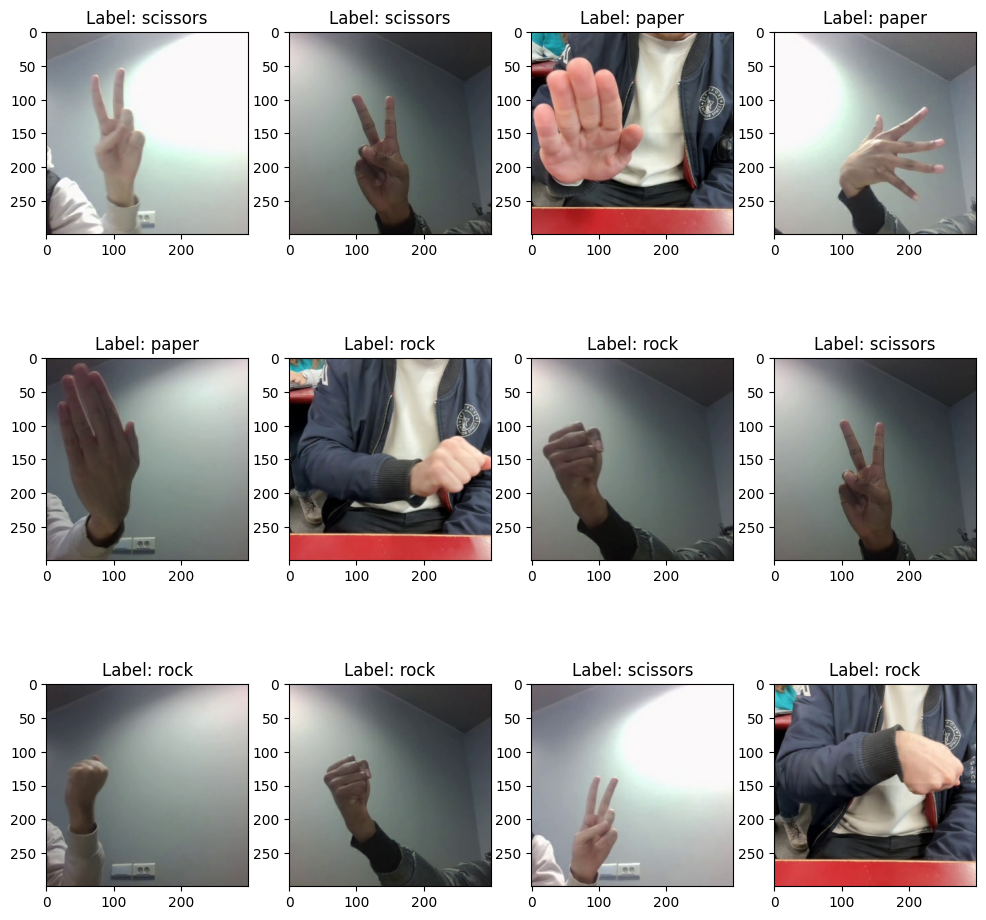

In [9]:
# Explore raw training dataset images.
preview_dataset(dataset_train_raw)

In [10]:
def format_example(features):
    image = features['image']
    label = features['label']
    # Make image color values to be float.
    image = tf.cast(image, tf.float32)
    # Make image color values to be in [0..1] range.
    image = image / 255.
    # Make sure that image has a right size
    image = tf.image.resize(image, [INPUT_IMG_SIZE, INPUT_IMG_SIZE])
    return image, label

In [11]:
print(dataset_train_raw)
dataset_train = dataset_train_raw.map(format_example)
dataset_test = dataset_test_raw.map(format_example)
dataset_val = dataset_val_raw.map(format_example)

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


Label: 2 

Image shape: (150, 150, 3) 

[[[0.4627451  0.45882353 0.4509804 ]
  [0.46960783 0.46568626 0.45784312]
  [0.46470588 0.46078432 0.45294118]
  ...
  [0.9843137  0.9764706  0.98039216]
  [0.9843137  0.9764706  0.98039216]
  [0.9843137  0.9764706  0.98039216]]

 [[0.46470588 0.46078432 0.45294118]
  [0.46666667 0.4627451  0.45490196]
  [0.4617647  0.45784312 0.45      ]
  ...
  [0.9843137  0.9764706  0.98039216]
  [0.9843137  0.9764706  0.98039216]
  [0.9843137  0.9764706  0.98039216]]

 [[0.4745098  0.45882353 0.4627451 ]
  [0.4764706  0.46078432 0.45686275]
  [0.4745098  0.45882353 0.45490196]
  ...
  [0.9843137  0.9764706  0.98039216]
  [0.9843137  0.9764706  0.98039216]
  [0.9843137  0.9764706  0.98039216]]

 ...

 [[0.14313726 0.10392157 0.1392157 ]
  [0.14411765 0.10490196 0.14019608]
  [0.14705883 0.10098039 0.1382353 ]
  ...
  [0.70980394 0.6862745  0.6862745 ]
  [0.70392156 0.6843138  0.672549  ]
  [0.7009804  0.6813725  0.6696079 ]]

 [[0.14509805 0.10588235 0.1490196

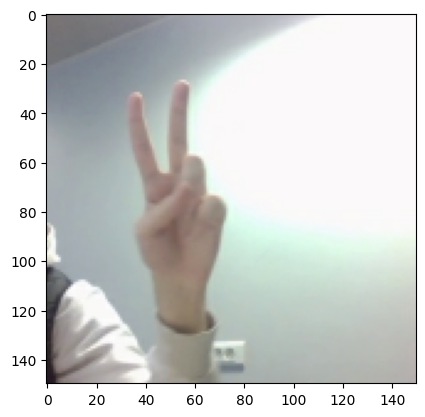

In [12]:
# Explore what values are used to represent the image.
(first_image, first_lable) = list(dataset_train.take(1))[0]
print('Label:', first_lable.numpy(), '\n')
print('Image shape:', first_image.numpy().shape, '\n')
print(first_image.numpy())
plt.imshow(first_image.numpy())

In [13]:
def augment_flip(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image

In [214]:
def augment_color(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_hue(image, max_delta=0.08)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    image = tf.image.random_brightness(image, 0.05)
    image = tf.image.random_contrast(image, lower=0.8, upper=1)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image

In [215]:
def augment_rotation(image: tf.Tensor) -> tf.Tensor:
    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(
        image,
        tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    )

In [216]:
def augment_inversion(image: tf.Tensor) -> tf.Tensor:
    random = tf.random.uniform(shape=[], minval=0, maxval=1)
    if random > 0.5:
        image = tf.math.multiply(image, -1)
        image = tf.math.add(image, 1)
    return image

In [217]:
def augment_zoom(image: tf.Tensor, min_zoom=0.8, max_zoom=1.0) -> tf.Tensor:
    print(image.shape)
    image_width, image_height, image_colors = image.shape
    crop_size = (image_width, image_height)

    # Generate crop settings, ranging from a 1% to 20% crop.
    scales = list(np.arange(min_zoom, max_zoom, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize(
            [img],
            boxes=boxes,
            box_indices=np.zeros(len(scales)),
            crop_size=crop_size
        )
        # Return a random crop
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]

    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

    # Only apply cropping 50% of the time
    return tf.cond(choice < 0.5, lambda: image, lambda: random_crop(image))

In [218]:
def augment_data(image, label):
    
    image = augment_flip(image)
    image = augment_color(image)
    image = augment_rotation(image)
    image = augment_zoom(image)
    image = augment_inversion(image)
    return image, label

In [219]:
#dataset_train = dataset_train.map(augment_data)

In [14]:
BATCH_SIZE = 32

# dataset_train = dataset_train.shuffle(
#     buffer_size=NUM_TRAIN_EXAMPLES
# )

# dataset_train = dataset_train.batch(
#     batch_size=BATCH_SIZE
# )

# # Prefetch will enable the input pipeline to asynchronously fetch batches while your model is training.
# dataset_train = dataset_train.prefetch(
#     buffer_size=tf.data.experimental.AUTOTUNE
# )

dataset_test = dataset_test.batch(BATCH_SIZE)
dataset_val = dataset_val.batch(BATCH_SIZE)

In [15]:
#Load model
model = tf.keras.models.load_model('rock_paper_scissors_cnn.keras')

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,946,952 (26.50 MB)

 Trainable params: 3,473,475 (13.25 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,473,477 (13.25 MB)

In [16]:
# Test model with our dataset
model.evaluate(dataset_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.3412 - loss: 6.2897


[5.768783092498779, 0.3499999940395355]

In [17]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['accuracy']
    val_accuracy = training_history.history['val_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()

In [18]:
def retrain(dataset_train, dataset_test, num_train_examples, num_test_examples):	
	model = tf.keras.models.load_model('rock_paper_scissors_cnn.keras')

	os.makedirs('logs/fit', exist_ok=True)
	tensorboard_log_dir = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
	tensorboard_callback = tf.keras.callbacks.TensorBoard(
			log_dir=tensorboard_log_dir,
			histogram_freq=1
	)

	os.makedirs('tmp/checkpoints', exist_ok=True)
	model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
			filepath='tmp/checkpoints/weights.{epoch:02d}-{val_loss:.2f}.keras'
	)

	early_stopping_callback = tf.keras.callbacks.EarlyStopping(
			patience=5,
			monitor='val_accuracy'
			# monitor='val_loss'
	)

	steps_per_epoch = num_train_examples // BATCH_SIZE
	validation_steps = num_test_examples // BATCH_SIZE

	print('steps_per_epoch:', steps_per_epoch)
	print('validation_steps:', validation_steps)

	# Train model with our dataset
	training_history = model.fit(
			x=dataset_train.repeat(),
			validation_data=dataset_val.repeat(),
			epochs=10,
			steps_per_epoch=steps_per_epoch,
			validation_steps=validation_steps,
			callbacks=[
					# model_checkpoint_callback,
					# early_stopping_callback,
					tensorboard_callback
			],
			verbose=1
	)

	#render_training_history(training_history)

	test_loss, test_accuracy = model.evaluate(dataset_test, verbose=1)

	# Return last val accuracy from history
	return test_accuracy

# Active Learning

## Random Sampling

In [19]:
def retrain_model_random(percentage_of_dataset, dataset_train, dataset_test):
    # Select a percentage of dataset_train to train the model
    num_train = int(NUM_TRAIN_EXAMPLES * percentage_of_dataset)
    print(f"Using {num_train} examples to train the model")

    dataset_train_shuffle = dataset_train.shuffle(buffer_size=NUM_TRAIN_EXAMPLES)
    dataset_train_shuffle_batch = dataset_train_shuffle.batch(BATCH_SIZE)
    dataset_train_random = dataset_train_shuffle_batch.take(num_train)

    return retrain(dataset_train_random, dataset_test, num_train, NUM_TEST_EXAMPLES)

In [20]:
def get_train_random(percentage):
	# Average accuracy from 5 tries
	average_accuracy = 0
	accuracies = []
	
	for i in range(5):
		accuracy = retrain_model_random(percentage, dataset_train, dataset_test)
		accuracies.append(accuracy)
		average_accuracy += accuracy
		print(f"Accuracy: {accuracy}")

	average_accuracy /= 5
	print(f"Average accuracy: {average_accuracy}")

	# Get confidence interval
	accuracies = np.array(accuracies)
	std_dev = np.std(accuracies)
	confidence_interval = 1.96 * std_dev / np.sqrt(5)
	print(f"Confidence interval: {confidence_interval}")

	return average_accuracy, average_accuracy - confidence_interval, average_accuracy + confidence_interval

Using 33 examples to train the model
steps_per_epoch: 1
validation_steps: 22
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.2812 - loss: 5.2696 - val_accuracy: 0.3949 - val_loss: 1.2940
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2188 - loss: 1.5725 - val_accuracy: 0.4433 - val_loss: 1.0451
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5312 - loss: 0.9892 - val_accuracy: 0.4259 - val_loss: 1.0823
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2812 - loss: 1.1037 - val_accuracy: 0.4942 - val_loss: 1.0217
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5312 - loss: 0.8945 - val_accuracy: 0.5305 - val_loss: 1.0078
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4375 - loss: 1.2457 - val_accuracy: 0.5276 - val_loss: 0.9978
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5000 - loss: 1.0155 - val_accuracy: 0.5669 - val_loss: 0.9517
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4

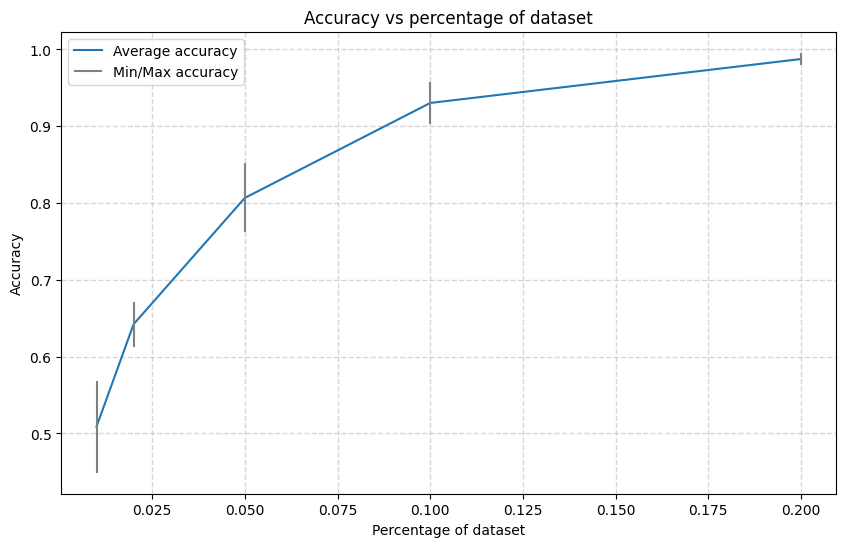

Random averages: [0.5088889002799988, 0.6422222256660461, 0.8066666603088379, 0.9302777767181396, 0.9875]
Random mins: [np.float64(0.4489080200302934), np.float64(0.6127155483359634), np.float64(0.7617086029002195), np.float64(0.9025015032471644), np.float64(0.9793152063757752)]
Random maxs: [np.float64(0.5688697805297042), np.float64(0.6717289029961289), np.float64(0.8516247177174564), np.float64(0.9580540501891148), np.float64(0.9956847936242249)]


In [21]:
random_averages = []
random_mins = []
random_maxs = []

percentages = [0.01, 0.02, 0.05, 0.1, 0.2]
for percentage in percentages:
	average_accuracy, min_accuracy, max_accuracy = get_train_random(percentage)
	random_averages.append(average_accuracy)
	random_mins.append(min_accuracy)
	random_maxs.append(max_accuracy)
	print('Percentage:', percentage, 'Average accuracy:', average_accuracy, 'Min accuracy:', min_accuracy, 'Max accuracy:', max_accuracy)


# Plot the results
# Show the average accuracy in a line and the min and max accuracy in a shaded area
plt.figure(figsize=(10, 6))
plt.plot(percentages, random_averages, label='Average accuracy')
plt.vlines(percentages, random_mins, random_maxs, color='gray', label='Min/Max accuracy')
plt.xlabel('Percentage of dataset')
plt.ylabel('Accuracy')
plt.title('Accuracy vs percentage of dataset')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)
plt.show()

print('Random averages:', random_averages)
print('Random mins:', random_mins)
print('Random maxs:', random_maxs)


## Least confidence sampling

In [25]:
def least_confidence(model, percentage, dataset_train):
    """
    Sélectionne les échantillons les moins confiants pour l'entraînement basé sur un modèle de deep learning.
    
    Args:
        model: Modèle TensorFlow entraîné pour effectuer des prédictions.
        percentage: Pourcentage des données à sélectionner (entre 0 et 1).

    Returns:
        dataset_train_least_confidence: Dataset TensorFlow contenant les échantillons sélectionnés.
        steps_per_epoch: Nombre d'étapes nécessaires par époque en fonction de la taille des données sélectionnées.
    """
    uncertainty_dict = {}  
    dataset_size = 0

    dataset_train_batch = dataset_train.batch(BATCH_SIZE)
    for idx, (images, labels) in enumerate(dataset_train_batch):  # Itération sur les batches
        dataset_size += len(images)
        preds = model(images, training=False)  # Prédictions pour le batch (pas d'entraînement)
        
        # Calcul de l'incertitude pour chaque échantillon dans le batch
        uncertainties = 1 - np.max(preds.numpy(), axis=1)
        
        for i, uncertainty in enumerate(uncertainties):
            # Stockage de l'incertitude pour chaque échantillon
            uncertainty_dict[idx * BATCH_SIZE + i] = uncertainty  # idx * batch_size + i pour obtenir un index global

    num_samples = int(percentage * dataset_size)
    print(f'Number of training examples: {num_samples}')
    
    # Tri des échantillons par incertitude (les plus incertains en premier)
    sorted_indices = sorted(uncertainty_dict.items(), key=lambda x: x[1], reverse=True)
    
    # Sélection des indices des n échantillons les plus incertains
    selected_indices = [idx for idx, _ in sorted_indices[:num_samples]]

    selected_images = []
    selected_labels = []
    for idx in selected_indices:
        image, label = list(dataset_train)[idx]
        selected_images.append(image)
        selected_labels.append(label)

    # Création d'un dataset TensorFlow à partir des images et labels sélectionnés
    dataset_train_least_confidence = tf.data.Dataset.from_tensor_slices((selected_images, selected_labels))
    dataset_train_least_confidence = dataset_train_least_confidence.shuffle(buffer_size=num_samples)
    dataset_train_least_confidence = dataset_train_least_confidence.batch(BATCH_SIZE)

    return dataset_train_least_confidence

In [26]:
def retrain_model_least_confidence(percentage_of_dataset, dataset_train, dataset_test):
    # Select a percentage of dataset_train to train the model
    num_train = int(NUM_TRAIN_EXAMPLES * percentage_of_dataset)
    print(f"Using {num_train} examples to train the model")
    dataset_train_least = least_confidence(tf.keras.models.load_model('rock_paper_scissors_cnn.keras'), percentage_of_dataset, dataset_train)

    return retrain(dataset_train_least, dataset_test, num_train, NUM_TEST_EXAMPLES)

Using 33 examples to train the model
Number of training examples: 33
steps_per_epoch: 1
validation_steps: 22
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4375 - loss: 1.0759 - val_accuracy: 0.3537 - val_loss: 4.0788
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.3373 - val_accuracy: 0.3387 - val_loss: 3.7472
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5000 - loss: 1.6546 - val_accuracy: 0.2892 - val_loss: 2.6607
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.6087 - val_accuracy: 0.2922 - val_loss: 3.1797
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1250 - loss: 3.2013 - val_accuracy: 0.3837 - val_loss: 1.7595
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step - accuracy: 1.0000 - loss: 0.3890 - val_accuracy: 0.3852 - val_loss: 1.9721
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7188 - loss: 0.5142 - val_accuracy: 0.3779 - val_loss: 2.2329
Epoch 8/10
1/1 ━━━━━━━━━━━━

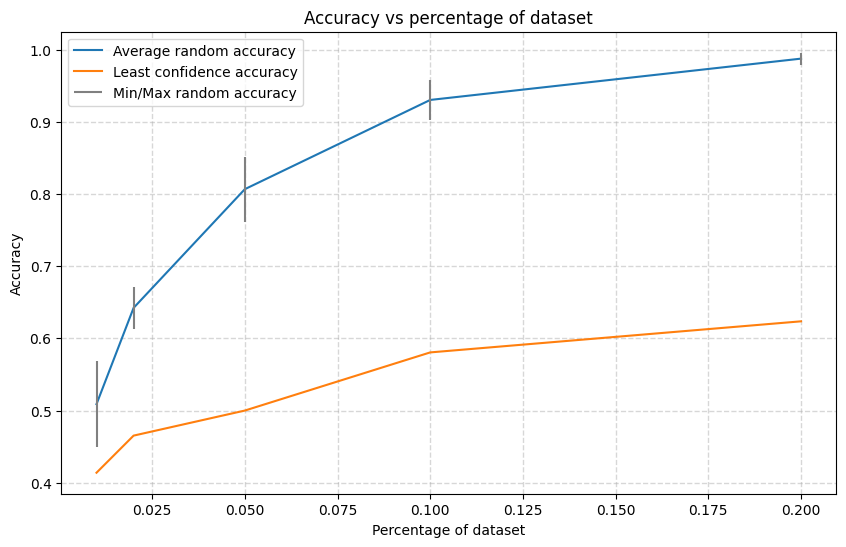

In [27]:
least_accuracies = []

for percentage in percentages:
    least_accuracies.append(retrain_model_least_confidence(percentage, dataset_train, dataset_test))

plt.figure(figsize=(10, 6))
plt.plot(percentages, random_averages, label='Average random accuracy')
plt.plot(percentages, least_accuracies, label='Least confidence accuracy')
plt.vlines(percentages, random_mins, random_maxs, color='gray', label='Min/Max random accuracy')
plt.xlabel('Percentage of dataset')
plt.ylabel('Accuracy')
plt.title('Accuracy vs percentage of dataset')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)
plt.show()

print('Least confidence accuracies:', least_accuracies)

# Diversity method

## Outlier sampling

In [31]:
from numpy.linalg import norm as euclidean_dis

def outlier_sampling(model, dataset_train, percentage):

	# Parcourir le dataset en batch pour collecter toutes les prédictions
	all_preds = []
	dataset_size = 0
	dataset_train_batch = dataset_train.batch(BATCH_SIZE)
	for idx, (images, labels) in enumerate(dataset_train_batch):
			preds = model(images, training=False)  # Prédictions sur le batch
			all_preds.append(preds.numpy())
			dataset_size += len(images)
	all_preds = np.vstack(all_preds)  # Convertir en une seule matrice
	mean_pred = np.mean(all_preds, axis=0)  # Moyenne des prédictions globales

	num_samples = int(percentage * dataset_size)

	# Liste pour stocker les distances aux prédictions moyennes
	distances = []
	selected_images_raw = []
	selected_labels_raw = []
	# Calculer la distance entre chaque prédiction et la prédiction moyenne
	for idx, (images, labels) in enumerate(dataset_train_batch):
			preds = model(images, training=False)  # Prédictions sur le batch
			batch_distances = euclidean_dis(preds.numpy() - mean_pred, axis=1)  # Distance euclidienne
			distances.extend(batch_distances)
			selected_images_raw.extend(images.numpy())  # Ajouter les images du batch
			selected_labels_raw.extend(labels.numpy())  # Ajouter les labels du batch

	# Trier les distances et récupérer les indices des outliers (distances les plus grandes)
	sorted_indices = np.argsort(distances)[-num_samples:]

	# Sélectionner les images et labels correspondants aux indices des outliers
	selected_images = [selected_images_raw[idx] for idx in sorted_indices]
	selected_labels = [selected_labels_raw[idx] for idx in sorted_indices]

	# Créer un nouveau dataset TensorFlow à partir des images et labels sélectionnés
	dataset_train_outliers = tf.data.Dataset.from_tensor_slices((selected_images, selected_labels))
	dataset_train_outliers = dataset_train_outliers.shuffle(buffer_size=num_samples)
	dataset_train_outliers = dataset_train_outliers.batch(BATCH_SIZE)

	return dataset_train_outliers

In [32]:
def retrain_model_outlier(percentage_of_dataset, dataset_train, dataset_test):
    # Select a percentage of dataset_train to train the model
    num_train = int(NUM_TRAIN_EXAMPLES * percentage_of_dataset)
    print(f"Using {num_train} examples to train the model")
    dataset_train_outlier = outlier_sampling(tf.keras.models.load_model('rock_paper_scissors_cnn.keras'), dataset_train, percentage_of_dataset)

    return retrain(dataset_train_outlier, dataset_test, num_train, NUM_TEST_EXAMPLES)

Using 33 examples to train the model
steps_per_epoch: 1
validation_steps: 22
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4688 - loss: 2.1854 - val_accuracy: 0.3395 - val_loss: 3.1810
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.4630 - val_accuracy: 0.3387 - val_loss: 4.1584
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6562 - loss: 1.1669 - val_accuracy: 0.3663 - val_loss: 3.0927
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step - accuracy: 0.0000e+00 - loss: 0.7425 - val_accuracy: 0.3590 - val_loss: 2.9202
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9375 - loss: 0.4033 - val_accuracy: 0.3517 - val_loss: 2.9579
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step - accuracy: 1.0000 - loss: 0.0834 - val_accuracy: 0.3517 - val_loss: 2.9083
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.2163 - val_accuracy: 0.3488 - val_loss: 3.1185
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - acc

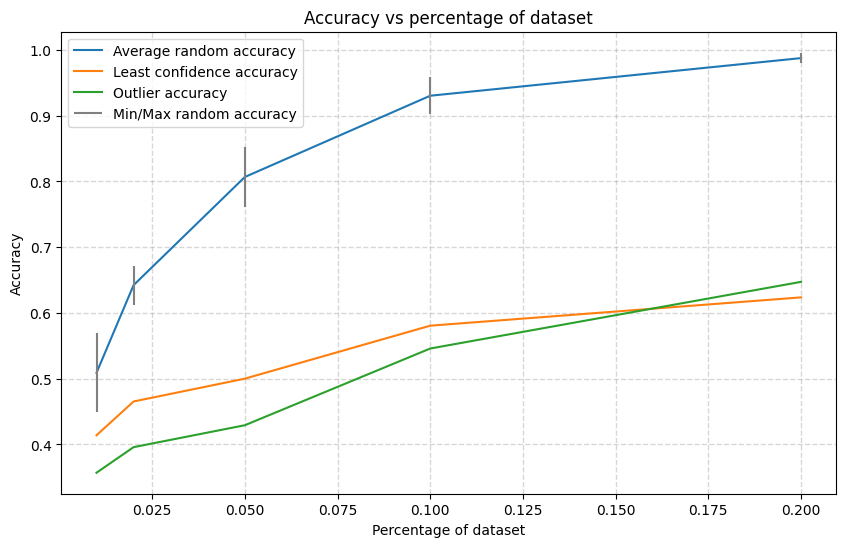

In [34]:
outlier_accuracies = []

for percentage in percentages:
    outlier_accuracies.append(retrain_model_outlier(percentage, dataset_train, dataset_test))

plt.figure(figsize=(10, 6))
plt.plot(percentages, random_averages, label='Average random accuracy')
plt.plot(percentages, least_accuracies, label='Least confidence accuracy')
plt.plot(percentages, outlier_accuracies, label='Outlier accuracy')
plt.vlines(percentages, random_mins, random_maxs, color='gray', label='Min/Max random accuracy')
plt.xlabel('Percentage of dataset')
plt.ylabel('Accuracy')
plt.title('Accuracy vs percentage of dataset')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)
plt.show()

print('Outlier accuracies:', outlier_accuracies)

# Entropy sampling

In [36]:
from scipy.stats import entropy

def entropy_sampling(model, dataset_train, percentage):
	entropies = []
	images = []
	labels = []
	dataset_size = 0

	dataset_train_batch = dataset_train.batch(BATCH_SIZE)
	for idx, (image_btach, labels_batch) in enumerate(dataset_train_batch):  # Itération sur les batches
		dataset_size += len(image_btach)
		preds = model(image_btach, training=False)  # Prédictions pour le batch (pas d'entraînement)
		
		entropies.extend(entropy(preds.numpy().T))

		# Appliquer la fonction d'entropie de SciPy pour chaque batch
		batch_entropies = entropy(preds.numpy().T)  # Entropie de Shannon pour chaque image
		entropies.extend(batch_entropies)
		images.extend(image_btach.numpy())  # Ajouter les images du batch
		labels.extend(labels_batch.numpy())  # Ajouter les labels du batch

	num_samples = int(percentage * dataset_size)
	print(f'Number of training examples: {num_samples}')

	# Trier les entropies et récupérer les indices des plus incertains (avec la plus grande entropie)
	sorted_indices = np.argsort(entropies)[-num_samples:]

	# Sélectionner les images et labels correspondants aux indices les plus incertains
	selected_images = [images[idx] for idx in sorted_indices]
	selected_labels = [labels[idx] for idx in sorted_indices]

	# Créer un nouveau dataset TensorFlow à partir des images et labels sélectionnés
	dataset_train_entropy_based = tf.data.Dataset.from_tensor_slices((selected_images, selected_labels))
	dataset_train_entropy_based = dataset_train_entropy_based.shuffle(buffer_size=num_samples)
	dataset_train_entropy_based = dataset_train_entropy_based.batch(BATCH_SIZE)

	return dataset_train_entropy_based

In [37]:
def retrain_model_entropy(percentage_of_dataset, dataset_train, dataset_test):
		# Select a percentage of dataset_train to train the model
		num_train = int(NUM_TRAIN_EXAMPLES * percentage_of_dataset)
		print(f"Using {num_train} examples to train the model")
		dataset_train_entropy = entropy_sampling(tf.keras.models.load_model('rock_paper_scissors_cnn.keras'), dataset_train, percentage_of_dataset)

		return retrain(dataset_train_entropy, dataset_test, num_train, NUM_TEST_EXAMPLES)

Using 33 examples to train the model
steps_per_epoch: 1
validation_steps: 22
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4688 - loss: 2.2187 - val_accuracy: 0.3381 - val_loss: 3.3930
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0000e+00 - loss: 0.7241 - val_accuracy: 0.3517 - val_loss: 4.2579
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6562 - loss: 0.8671 - val_accuracy: 0.3459 - val_loss: 3.4330
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 1.0000 - loss: 0.6722 - val_accuracy: 0.3576 - val_loss: 3.7279
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9688 - loss: 0.2817 - val_accuracy: 0.3590 - val_loss: 3.7580
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step - accuracy: 1.0000 - loss: 0.1388 - val_accuracy: 0.3648 - val_loss: 3.9309
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8750 - loss: 0.1964 - val_accuracy: 0.3677 - val_loss: 4.0866
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accura

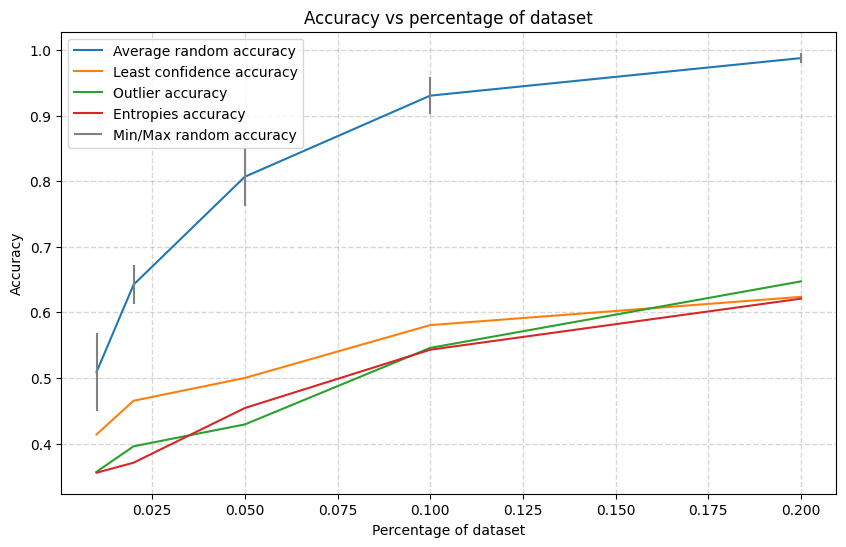

Entropy accuracies: [0.35555556416511536, 0.3708333373069763, 0.4541666805744171, 0.543055534362793, 0.6208333373069763]


In [38]:
entropy_accuracies = []

for percentage in percentages:
    entropy_accuracies.append(retrain_model_outlier(percentage, dataset_train, dataset_test))

plt.figure(figsize=(10, 6))
plt.plot(percentages, random_averages, label='Average random accuracy')
plt.plot(percentages, least_accuracies, label='Least confidence accuracy')
plt.plot(percentages, outlier_accuracies, label='Outlier accuracy')
plt.plot(percentages, entropy_accuracies, label='Entropies accuracy')
plt.vlines(percentages, random_mins, random_maxs, color='gray', label='Min/Max random accuracy')
plt.xlabel('Percentage of dataset')
plt.ylabel('Accuracy')
plt.title('Accuracy vs percentage of dataset')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)
plt.show()

print('Entropy accuracies:', entropy_accuracies)